Name: Shobhit Verma<br>
Class: BE COMPS<br>
Batch: D<br>
Roll No: 33<br>
UID: 2018130062<br>

# Experiment - 6

# Contents table

- [0. Preamble](#0.)
    - [0.1 Description](#0.1)
    - [0.2 Imports](#0.2)
- [1. Importing and visualising](#1.)
    - [1.1 Importing data](#1.1)
    - [1.2 Clenaing data](#1.2)
    - [1.3 Visualising data](#1.3)
- [2. Statistics](#2.)
    - [2.1 Percentage Change](#2.1)
    - [2.2 Returns](#2.2)
    - [2.3 Comparing Time Series](#2.3)
- [3. Decomposing Data](#3.)
    - [3.1 Main Components](#3.1)
- [4. Forecasting with an LSTM](#4.)
    - [4.1 Preparing Data](#4.1)
    - [4.2 Modelling](#4.2)
    - [4.3 Results](#4.3)

# <a id='0.'> 0. Preamble </a>

### <a id='0.1'> 0.1 Description </a>

## Aim

In this notebook I aim to analyse the historical stock data for FTSE, S&P, DAX, and NIKKEI stock - from 1994-2018. The notebook includes visualisations, comparisons, and forecasting, both naively and using Auto Regressive Moving Averages (ARMA) model. <br> <br>For the forecasting I will be focusing on the SPX stock

## Data Description

##### All values are the price of the stock at close time, in dollars $

- 'spx' is the S&P 500 gauge of U.S Equities
- 'dax' is a total return index of 30 selected German blue chip stocks
- 'ftse' is a share index of the top 100 companies listed on the London Stock Exchange
- 'nikkei' is a price-weighted average of 225 top-rated Japanese companies listed on Tokyo Stock Exchange



### <a id ='0.2'> 0.2 Imports </a>

In [2]:
#Importing stuff
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import sklearn.metrics
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns
%pylab inline
sns.set(style="darkgrid") #Comment out if pyplot style is wanted

import datetime as dt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
from sklearn.preprocessing import MinMaxScaler

import os
print(f"filename: {os.listdir('../input/financial-markets')}")

Populating the interactive namespace from numpy and matplotlib
filename: ['Index2018.csv']


In [3]:
#Class to help with formatting printed text
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

# <a id='1.'> 1. Importing and visualising </a>

### <a id ='1.1'> 1.1 Importing data </a>

In [4]:
data = pd.read_csv('../input/financial-markets/Index2018.csv',
                   parse_dates=['date'],
                   date_parser = (lambda date: dt.datetime.strptime(date,'%d/%m/%Y'))
                   ,index_col='date')      

data.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


### <a id = '1.2'> 1.2 Cleaning Data </a>

In [5]:
print(color.BOLD + 'Description of data:' + color.END)
print(data.describe())

print(color.BOLD + '\nNumber of Null values:' + color.END)
data.isna().sum()

Description of data:
               spx           dax         ftse        nikkei
count  6269.000000   6269.000000  6269.000000   6269.000000
mean   1288.127542   6080.063363  5422.713545  14597.055700
std     487.586473   2754.361032  1145.572428   4043.122953
min     438.920000   1911.700000  2876.600000   7054.980000
25%     990.671905   4069.350000  4486.100000  10709.290000
50%    1233.420000   5773.340000  5662.430000  15028.170000
75%    1459.987747   7443.070000  6304.250000  17860.470000
max    2872.867839  13559.600000  7778.637689  24124.150000

Number of Null values:


spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

Here we can see we don't actually have any na values. We've already formatted 'Date' and made it the index. This means we have no data cleaning to do!

### <a id='1.3'> 1.3 Visualising Data </a>

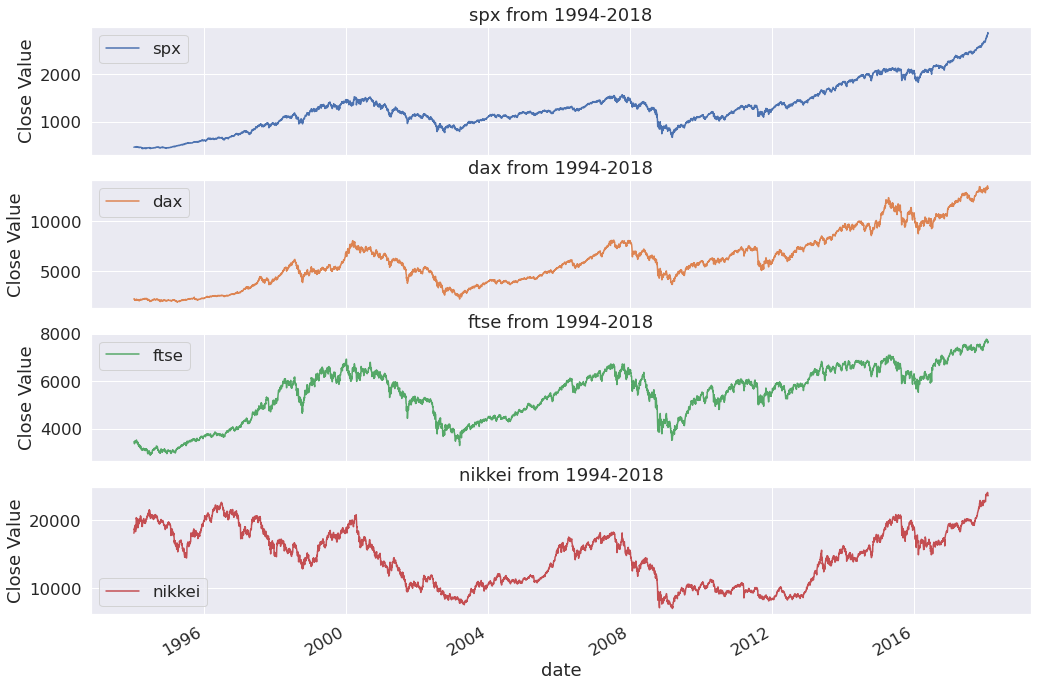

In [6]:
sns.set(font_scale=(1.5))
data.plot(subplots=True, figsize=(15,12),ylabel =('Close Value'),
                         title = ['spx from 1994-2018','dax from 1994-2018',
                                  'ftse from 1994-2018','nikkei from 1994-2018',])
plt.savefig('stocks.png')
plt.show()

##### We will be focusing on the ftse and spx stocks

# <a id='2.'> 2. Statistics </a>

## <a id='2.1'> 2.1 Percentage Change </a>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9c334cf90>,
      dtype=object)

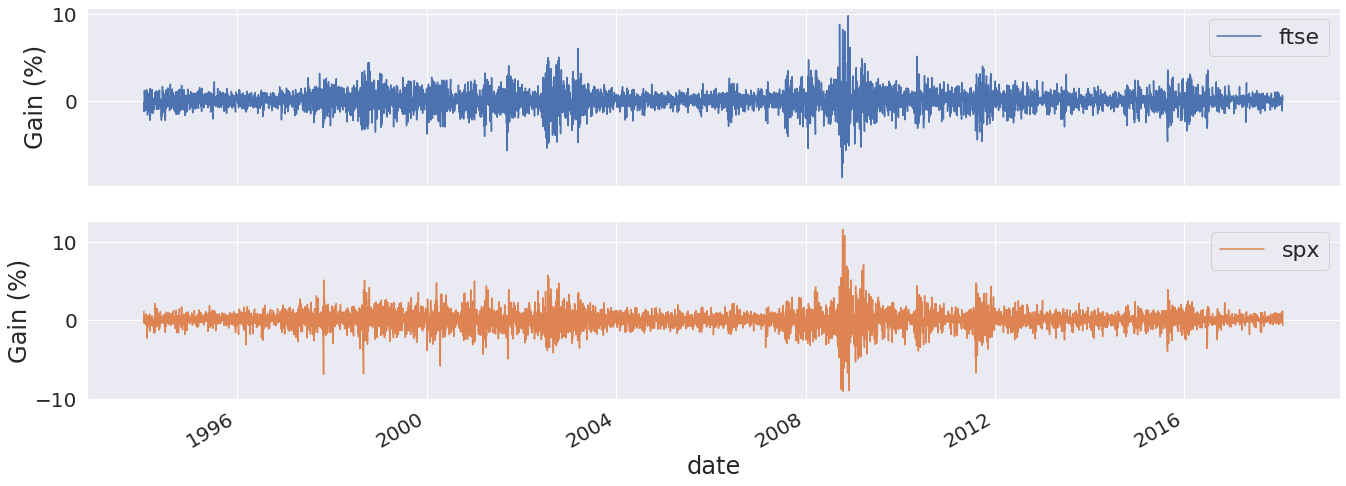

In [7]:
sns.set(font_scale=2.0)
data[['ftse','spx']].pct_change().multiply(100).plot(subplots=True,figsize=(20,8),fontsize=20,ylabel='Gain (%)')


## <a id =2.2> 2.2 Returns </a>

#### Note the different scales!

Absolute returns for all 4 stocks


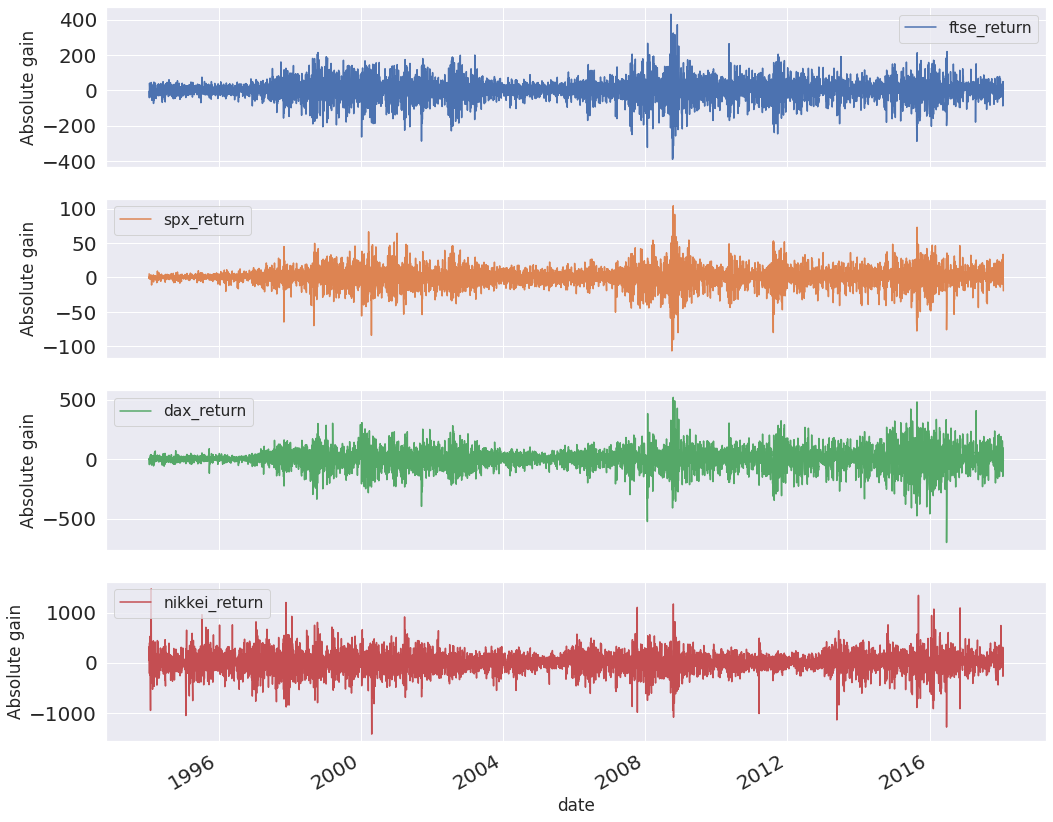

In [8]:
sns.set(font_scale=(1.4))
data['ftse_return'] = data.ftse.diff() 
data['spx_return'] = data.spx.diff()
data['dax_return'] = data.dax.diff()
data['nikkei_return'] = data.nikkei.diff()
data[['ftse_return',
'spx_return',
'dax_return',
'nikkei_return']].plot(subplots=True,figsize=(15,15),fontsize=20,ylabel='Absolute gain',legend=True)

print(color.BOLD + 'Absolute returns for all 4 stocks' + color.END)

Of course, a higher absolute gain does not necessarily indicate a 'better' stock. Let us now compare the growth of the stocks

## <a id = '2.3'> 2.3 Comparing Time Series </a>

In order to effectively compare the time series we need to format the data, so the stocks start at the same value <br>
To do this we will divide each series by its respective starting value, and multiply by 100 for more similarity with original

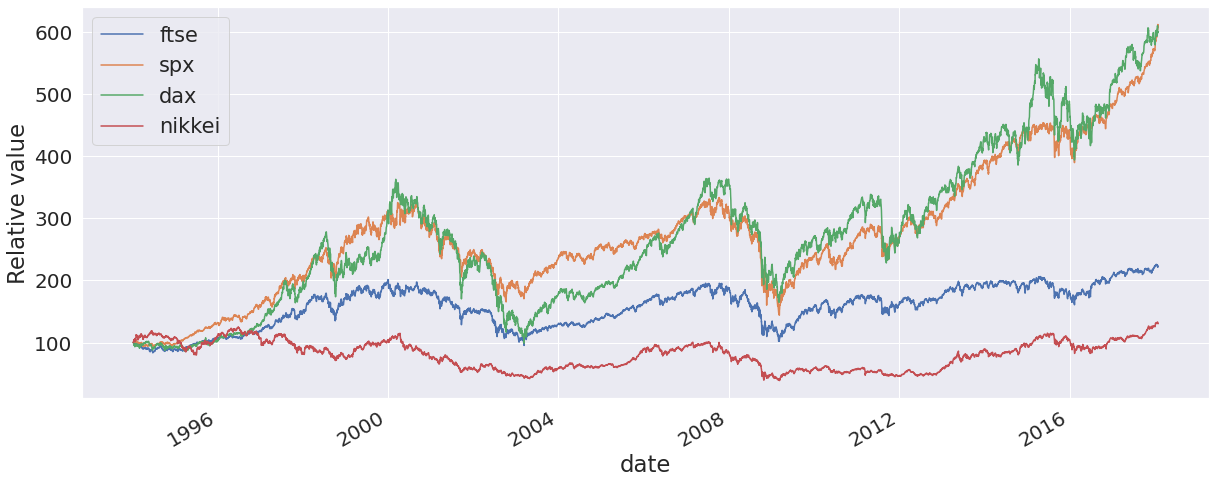

In [9]:
format_ftse = data.ftse.divide(data.ftse.iloc[0]).multiply(100)
format_spx = data.spx.divide(data.spx.iloc[0]).multiply(100)
format_nikkei = data.nikkei.divide(data.nikkei.iloc[0]).multiply(100)
format_dax = data.dax.divide(data.dax.iloc[0]).multiply(100)

sns.set(font_scale=(1.9))
format_ftse.plot(fontsize=20,ylabel='Relative value',legend=True)
format_spx.plot(fontsize=20,ylabel='Relative value',legend=True)
format_dax.plot(fontsize=20,ylabel='Relative value',legend=True)
format_nikkei.plot(figsize=(18,8),fontsize=20,ylabel='Relative value',legend=True)

Here we can see that spx and dax have significantly outperformed the ftse & nikkei, in terms of value gain.

# <a id=3.> 3. Decomposing data</a>

## <a i='3.1'> 3.1 Main components </a>

A time series such at these, can be decomposed into 3 main building blocks: <br>
- Trend - General direction of data
- Seasonality - trends which repeat after a given interval
- Noise - 'random' fluctuations in values

We will break down the SPX into these 3 components

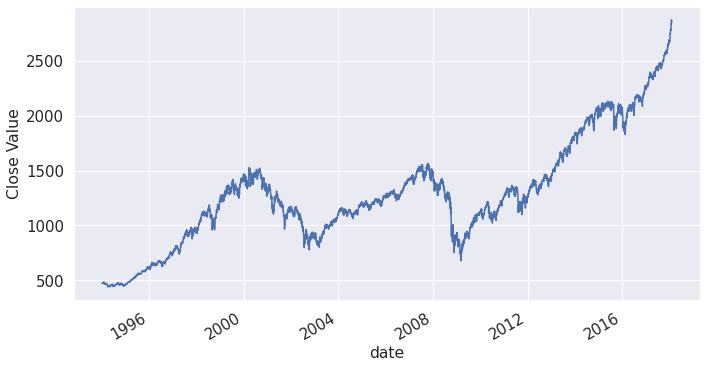

In [10]:
#First lets view just SPX
sns.set(font_scale=(1.3))
data.spx.plot(figsize=(10,6),fontsize=15,ylabel='Close Value')

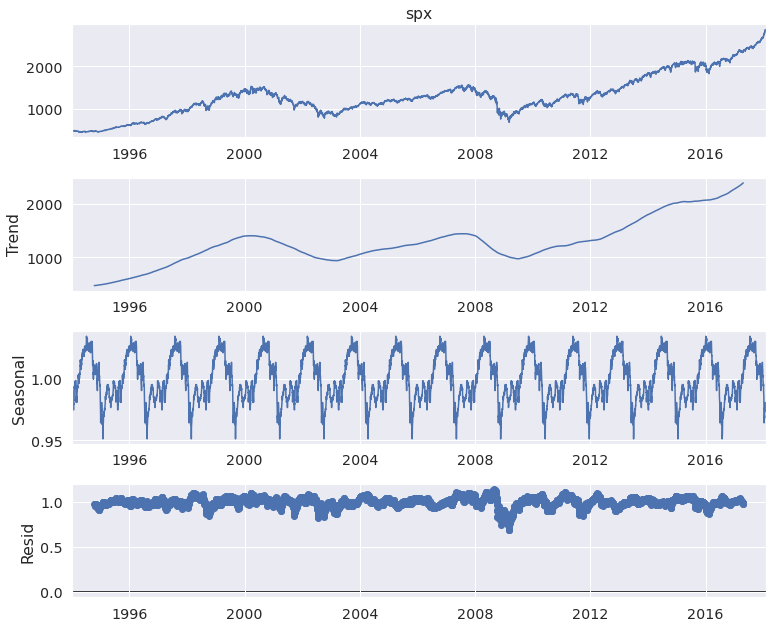

In [11]:
#We will use statsmodels' seasonal decomposer (multiplicitive)
#So, ftse[t] = Trend[t] * Seasonal[t] * Noise[t]

import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 11, 9
spx_decomposed = sm.tsa.seasonal_decompose(data.spx,period=400,model='multiplicative') #yearly seasonality

spx_decomposed.plot()
plt.show()

Generally an upward trend in the plot, though there is clearly exceptions (dot.com crash of 2000 and the american financial crisis of sept 2008)

We also see the seasonality is not particularly strong - making predicitons by hand harder



## <a id='4.'> 4. Forecasting with ARMA </a>

I'll split the data into train and validation, in order to quantify the accuracy of the model

## <a id='4.1'> 4.1 Preparing Data </a>

First I will make a numpy array from the relevant data

In [12]:
dataset = data.spx #this is the stock data we want
dataset = np.array(dataset.values) #turning into an array

print(color.BOLD + 'dataset peak:\n' + color.END,dataset)

#getting the length of training data, with a 80/20 split (ish, not quite divisible perfectly)
training_len = int(len(dataset)*0.80//1 -15)

test_len = int(len(dataset) - training_len)

print(('\ntraining length: {}\ntest length: {}').format(training_len,test_len))

dataset peak:
 [ 469.9       475.27      474.13     ... 2839.253031 2872.867839
 2853.528411]

training length: 5000
test length: 1269


We should scale the train&test data before hand, to avoid problems such as exploding or vanishing gradient

In [13]:
#Applying scaling using Sklearn's MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))

#Now splitting data into train and test
train_data = scaled_data[:training_len,:]
test_data = scaled_data[training_len-50:,:]

Before we can pass the data into an Neural Network, we need to make sure the data is windowed, so the model can use historic data from periods longer than 1

#### Windowing data

In [14]:
x_train = []
y_train = []
x_test = []
window_size = 50

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
            
#Converting into numpy arrays to feed in model  
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

#data must be in a 3d array - as we have  amount of data points, window_size, and batch size
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1] , 1))
print('x_train shape: ', np.shape(x_train))
print('x_test_shape', np.shape(x_test))

x_train shape:  (4950, 50, 1)
x_test_shape (1269, 50, 1)


## <a id='4.2'> 4.2 Modelling </a>

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D , Dropout #Conv1d and Dropout didn't improve this model, so have been left out

model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25,activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='Adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

4950/4950 [==============================] - 135s 27ms/step - loss: 3.6349e-04


In [16]:
predictions = model.predict(x_test) #obtaining the models predictions
predictions = scaler.inverse_transform(predictions) #Obtaining actual predictions from the normalised predictions
predictions = predictions[:,0]
print(predictions)

[1522.9878 1525.6307 1527.366  ... 2674.1055 2678.7659 2689.4446]


## <a id='4.3'> 4.3 Results </a>

Text(0, 0.5, 'Close Price USD ($)')

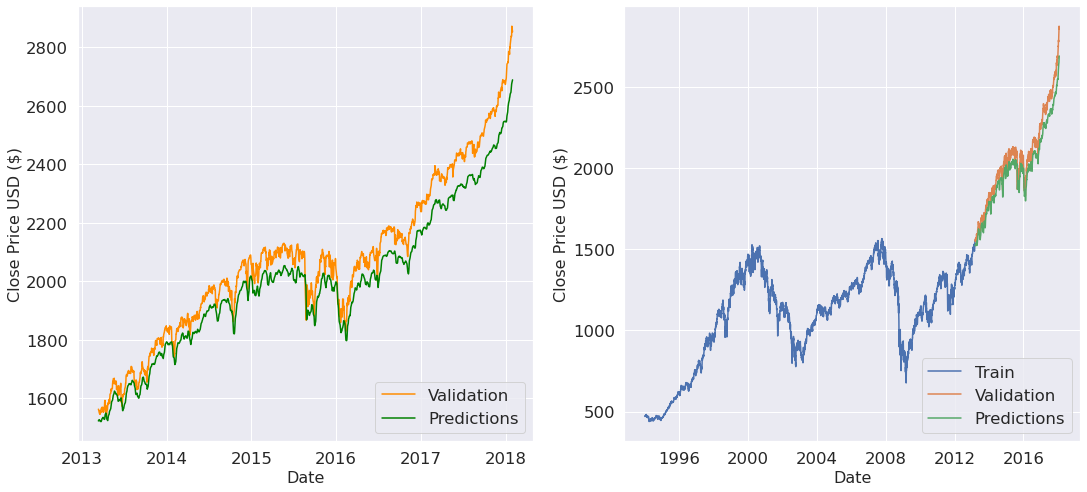

In [17]:
train = data.spx[:training_len]
validation = pd.DataFrame(data.spx[training_len:])
validation['Predictions'] = predictions

sns.set(font_scale=1.5)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax2.plot(train)
ax2.plot(validation[['spx','Predictions']])
ax2.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('Close Price USD ($)', fontsize=16)


ax1.plot(validation['spx'],color='darkorange')
ax1.plot(validation['Predictions'],color='green')
ax1.legend(['Validation','Predictions'],loc='lower right')
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Close Price USD ($)', fontsize=16)


The model seems to work very well for the validation period! Let us compare it to a naive forecast, which simply projects the previous days value to the next day

We also have an issue in that we don't particularly want to use data from 20 years ago to help train our model as it's not very relevant, but if we only use data from, say, the last 10 years, our model will be terrible at predicting any downturns. This is of course one of the big difficulties with stock data.

MAE of predictions: 73.7948394116738
MSE of predictions: 80.44664180977298

MSE of naive-forecast: 14.717568480990014


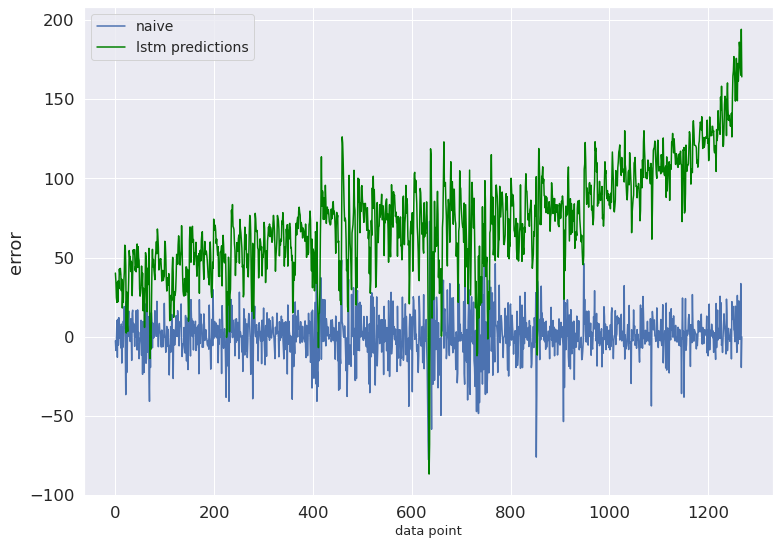

In [18]:
#'shifting' the data by 1, to get the naive forecasting, and duplicating the previous value to preserve lengths

naive = np.append(validation.spx.values[1:],validation.spx.values[-1])

#plotting
plt.plot(naive-validation.spx.values,label = 'naive')
plt.plot(validation.spx.values-predictions,color='green',label = 'lstm predictions')
plt.legend(fontsize=14)
plt.ylabel('error')
plt.xlabel('data point',fontsize=13)

print('MAE of predictions:',sklearn.metrics.mean_absolute_error(validation.spx.values,predictions))
print('MSE of predictions:',sklearn.metrics.mean_squared_error(validation.spx.values,predictions)**0.5)
print('\nMSE of naive-forecast:',np.mean(np.square((validation.spx.values-naive)))**0.5)

Although these results look promising on first inspection (as only 1 epoch trained on), after comparing with a naive forecast we can see that the two models do very similar things. This is explained as in real stock prices have so many variables which can't really be accounted for in a model such as this. Hence, the optimal solution for the ARMA is not too disimilar from simply a random walk , which trails by 1 day.

# Conclusion:

1. Through EDA on the dataset, we found that spx and dax have significantly outperformed the ftse & nikkei, in terms of value gain.

2. During pre-processing, decomposed the data into 3 main building blocks: <br>
- Trend - General direction of data
- Seasonality - trends which repeat after a given interval
- Noise - 'random' fluctuations in values

3. Identified the trends in the 4 stocks, over a period of 20 years. Sharp drops were observed across all 4 indices after the 2008 economic crisis. Similarly, the Dot Com Boom of the late 90s and early 2000s led to a sharp increase in values of all 4 indices.

4. Realized that stock prediction necessitates not particularly using data from 20 years ago to help train our model as it's not very relevant, but if we only use data from, say, the last 10 years, our model will be terrible at predicting any downturns. This is one of the big difficulties with stock data.